In [2]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.SeqUtils import gc_fraction

import config_readwrite as crw
import glob

import matplotlib.pyplot as plt
import numpy as np
import os, sys

import pandas as pd

from scipy import stats
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from plot_params import fonts
from statsmodels.stats.multitest import fdrcorrection

In [7]:
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

section = "mpra"
FASTA = config[section]["fasta"]
MPRA = config[section]["HEPG2.clean"]
BUILD = "hg38"

section = "FIMO"
FIMO_PATH = "/wynton/home/ahituv/fongsl/EMF/US/data/fimo"#config[section]["path"]
FIMO_PRED = os.path.join(FIMO_PATH, "fimo.txt")#config[section]["pred"]
FIMO_MOTIF_MAX = os.path.join(FIMO_PATH, "fimo_motif.max_score.tsv.gz")

FIMO_MOTIF_MAX_TABLE = os.path.join(FIMO_PATH, "fimo_motif.max_score_table.tsv.gz")
FIMO_MOTIF_MAX_PTABLE = os.path.join(FIMO_PATH, "fimo_motif.max_score_pvalue.table.tsv.gz")

# write
config[section]["max_score"]= FIMO_MOTIF_MAX
config[section]["max_score_table"]= FIMO_MOTIF_MAX_TABLE
config[section]["max_score_pval_table"]= FIMO_MOTIF_MAX_PTABLE

crw.write(config, cfn)


# set up fimo + jaspar run

In [4]:
def runFimo(input_file, build, config):
    
    FIMO = os.path.join(os.environ["HOME"], "tools", "genome", "fimo.sh") # .py if you want to run in cmd line
    if os.path.exists(config) is False:
        empty_config = os.path.join(os.getcwd(), "config.ini")
        os.system(f"touch {empty_config}")
    
    cmd = " ".join([
        "qsub", 
        FIMO,
        input_file,
        f"-c {config}",
        f"-g {build}"
    ])
    print("running fimo", cmd)
    os.system(cmd)

## run

In [5]:
if os.path.exists(FIMO_PRED) is False:
    runFimo(FASTA, BUILD, cfn)

# GC content 

In [8]:
gc = {}
with open(FASTA) as handle:

    for values in SimpleFastaParser(handle):
        name, seq = values
        gc[name]=gc_fraction(seq)


In [9]:
# make a dataframe of GC values
gcdf = pd.DataFrame(gc.items())
gcdf.columns=["name", "gc"]  # rename columns

gcdf.head()

,name,gc
0,bj_k27ac_down_chr3:29837526-29837795,0.281481
1,bj_k27ac_down_chr3:29837260-29837529,0.281481
2,bj_k27ac_down_chr3:29837792-29838061,0.355556
3,bj_k27ac_down_chr3:29837392-29837661,0.303704
4,bj_k27ac_down_chr3:29837659-29837928,0.311111


<Axes: xlabel='gc', ylabel='Count'>

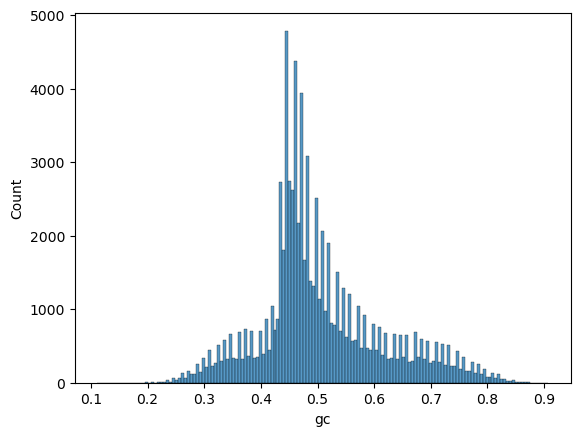

In [10]:
# histplot of % GC
sns.histplot(gcdf["gc"])

In [11]:
# summary stats of GC
gcdf["gc"].describe()

count    82427.000000
mean         0.505015
std          0.108679
min          0.111111
25%          0.444444
50%          0.481481
75%          0.559259
max          0.907407
Name: gc, dtype: float64

# MPRA ~ GC

In [ ]:
df = pd.read_csv(MPRA, sep='\t',)
df

## Merge MPRA w GC data

In [ ]:
m = pd.merge(df, gcdf)

### Missing MPRA data for some fasta sequences? 
- 23906 synthetic sequences are missing in intersection of fasta and MPRA dataframes. 
    - n= 11171/35077 synthetic sequences accounted for
- 100% covered:
    - DEG
    - ATAC
    - H3K27ac
    - Neg
    - pos
    - shuffle

In [ ]:
# count of names in merge of MPRA + GC 
m.groupby(["label"])['name'].count()

# count of names in MPRA dataframe
df.groupby(["label"])['name'].count()

### eval set difference, intersection

In [ ]:
gc_ = set(gcdf["name"])
n = set(df["name"])

len(gc_.difference(n)), len(gc_.intersection(n))

## Linear model

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('reg', LinearRegression())])

X = np.vstack(m["gc"])
y = np.vstack(m["logFC"])

pipe.fit(X, y)

print(pipe.score(X, y))

reg = pipe.named_steps["reg"]

## GC content is not associated with log2FC in activity
- r2 = 0.0056350045883429845, coeff = 0.02

In [ ]:
reg.coef_

# Fimo outputs

## split FIMO predictions per motif

In [12]:
# use awk command to split fimo motifs
cmd = " ".join([
                """awk '{print>$1".txt"}'""", 
                FIMO_PRED
                ])

# a test result file
TEST_SPLIT = os.path.join(FIMO_PATH, "MA0010.1.txt")

if os.path.exists(TEST_SPLIT) is False:
    os.system(cmd)

fs = glob.glob(os.path.join(FIMO_PATH, "*.txt"))


## get headers

In [19]:
# 
NAMES_FILE = os.path.join(FIMO_PATH, "motif_id.txt")
NAMES = list(pd.read_csv(NAMES_FILE, sep='\t'))

KEEP_COLS = [['motif_id',
             'sequence_name',
             'score',
             'p-value',
             'matched_sequence'
             ]]

## FDR correction per motif

In [29]:
for f in fs:
    handle = os.path.split(f)[1]  # get the file name

    if "MA" in handle:

        # open motif prediction file
        df = pd.read_csv(f, sep='\t', header=None, names=NAMES)

        # get vector of p values
        pvals = df["p-value"]

        # run FDR correction at alpha = 0.05
        df["reject_null"], df["FDR_P"] = fdrcorrection(pvals, alpha=0.05)

        if False in set(df["reject_null"]):
            print("some FP", handle)
        else:
            print("true-only", handle)

true-only MA0010.1.txt
true-only MA0011.1.txt
true-only MA0012.1.txt
true-only MA0013.1.txt
true-only MA0015.1.txt
true-only MA0016.1.txt
true-only MA0019.1.txt
true-only MA0022.1.txt
true-only MA0023.1.txt
true-only MA0026.1.txt
true-only MA0029.1.txt
true-only MA0030.1.txt
true-only MA0031.1.txt
true-only MA0034.1.txt
true-only MA0040.1.txt
true-only MA0049.1.txt
true-only MA0051.1.txt
true-only MA0054.1.txt
true-only MA0059.1.txt
true-only MA0066.1.txt
true-only MA0069.1.txt
true-only MA0070.1.txt
true-only MA0071.1.txt
true-only MA0072.1.txt
true-only MA0073.1.txt
true-only MA0074.1.txt
true-only MA0077.1.txt
true-only MA0082.1.txt
true-only MA0084.1.txt
true-only MA0085.1.txt
true-only MA0091.1.txt
true-only MA0092.1.txt
true-only MA0096.1.txt
true-only MA0097.1.txt
true-only MA0101.1.txt
true-only MA0107.1.txt
true-only MA0108.2.txt
true-only MA0111.1.txt
true-only MA0115.1.txt
true-only MA0116.1.txt
true-only MA0118.1.txt
true-only MA0119.1.txt
true-only MA0121.1.txt
true-only M

true-only MA0593.1.txt
true-only MA0595.1.txt
true-only MA0596.1.txt
true-only MA0599.1.txt
true-only MA0601.1.txt
true-only MA0602.1.txt
true-only MA0603.1.txt
true-only MA0604.1.txt
true-only MA0608.1.txt
true-only MA0610.1.txt
true-only MA0613.1.txt
true-only MA0614.1.txt
true-only MA0615.1.txt
true-only MA0618.1.txt
true-only MA0619.1.txt
true-only MA0621.1.txt
true-only MA0622.1.txt
true-only MA0626.1.txt
true-only MA0628.1.txt
true-only MA0629.1.txt
true-only MA0630.1.txt
true-only MA0631.1.txt
true-only MA0634.1.txt
true-only MA0007.3.txt
true-only MA0635.1.txt
true-only MA0636.1.txt
true-only MA0638.1.txt
true-only MA0639.1.txt
true-only MA0641.1.txt
true-only MA0027.2.txt
true-only MA0643.1.txt
true-only MA0645.1.txt
true-only MA0475.2.txt
true-only MA0042.2.txt
true-only MA0033.2.txt
true-only MA0646.1.txt
true-only MA0647.1.txt
true-only MA0648.1.txt
true-only MA0649.1.txt
true-only MA0131.2.txt
true-only MA0046.2.txt
true-only MA0153.2.txt
true-only MA0486.2.txt
true-only M

true-only MA1039.1.txt
true-only MA1040.1.txt
true-only MA1041.1.txt
true-only MA1042.1.txt
true-only MA1043.1.txt
true-only MA1044.1.txt
true-only MA1045.1.txt
true-only MA1046.1.txt
true-only MA1048.1.txt
true-only MA1049.1.txt
true-only MA1050.1.txt
true-only MA1051.1.txt
true-only MA1053.1.txt
true-only MA1054.1.txt
true-only MA1056.1.txt
true-only MA1057.1.txt
true-only MA1058.1.txt
true-only MA1060.1.txt
true-only MA1061.1.txt
true-only MA1063.1.txt
true-only MA1064.1.txt
true-only MA1066.1.txt
true-only MA1067.1.txt
true-only MA1071.1.txt
true-only MA1074.1.txt
true-only MA1075.1.txt
true-only MA1077.1.txt
true-only MA1078.1.txt
true-only MA1080.1.txt
true-only MA1084.1.txt
true-only MA1086.1.txt
true-only MA1088.1.txt
true-only MA1089.1.txt
true-only MA1090.1.txt
true-only MA1091.1.txt
true-only MA1092.1.txt
true-only MA1093.1.txt
true-only MA1095.1.txt
true-only MA1096.1.txt
true-only MA1097.1.txt
true-only MA1098.1.txt
true-only MA0852.2.txt
true-only MA0036.3.txt
true-only M

true-only MA1464.1.txt
true-only MA1466.1.txt
true-only MA1468.1.txt
true-only MA1101.2.txt
true-only MA1470.1.txt
true-only MA1471.1.txt
true-only MA1473.1.txt
true-only MA1474.1.txt
true-only MA1475.1.txt
true-only MA1478.1.txt
true-only MA1479.1.txt
true-only MA1480.1.txt
true-only MA1481.1.txt
true-only MA1484.1.txt
true-only MA1485.1.txt
true-only MA1489.1.txt
true-only MA1493.1.txt
true-only MA1494.1.txt
true-only MA1495.1.txt
true-only MA1496.1.txt
true-only MA1497.1.txt
true-only MA1499.1.txt
true-only MA1500.1.txt
true-only MA1501.1.txt
true-only MA1502.1.txt
true-only MA1503.1.txt
true-only MA1504.1.txt
true-only MA1505.1.txt
true-only MA1506.1.txt
true-only MA1507.1.txt
true-only MA1508.1.txt
true-only MA1509.1.txt
true-only MA1512.1.txt
true-only MA1513.1.txt
true-only MA1514.1.txt
true-only MA1515.1.txt
true-only MA1516.1.txt
true-only MA1517.1.txt
true-only MA1519.1.txt
true-only MA1520.1.txt
true-only MA1521.1.txt
true-only MA1522.1.txt
true-only MA1523.1.txt
true-only M

true-only MA1741.1.txt
true-only MA1742.1.txt
true-only MA1743.1.txt
true-only MA1744.1.txt
true-only MA1745.1.txt
true-only MA1746.1.txt
true-only MA1747.1.txt
true-only MA1748.1.txt
true-only MA1749.1.txt
true-only MA1750.1.txt
true-only MA1751.1.txt
true-only MA1752.1.txt
true-only MA1753.1.txt
true-only MA1754.1.txt
true-only MA1755.1.txt
true-only MA1756.1.txt
true-only MA1757.1.txt
true-only MA1758.1.txt
true-only MA1759.1.txt
true-only MA1760.1.txt
true-only MA1761.1.txt
true-only MA1762.1.txt
true-only MA1764.1.txt
true-only MA1765.1.txt
true-only MA1766.1.txt
true-only MA1767.1.txt
true-only MA1768.1.txt
true-only MA1769.1.txt
true-only MA1770.1.txt
true-only MA1771.1.txt
true-only MA1772.1.txt
true-only MA1773.1.txt
true-only MA1774.1.txt
true-only MA1775.1.txt
true-only MA1776.1.txt
true-only MA1777.1.txt
true-only MA1778.1.txt
true-only MA1779.1.txt
true-only MA1780.1.txt
true-only MA1781.1.txt
true-only MA1783.1.txt
true-only MA1784.1.txt
true-only MA1785.1.txt
true-only M

## function to get max motif score per sequence

In [17]:
def getMaxMotifScore(df):
    
    # get max motif score per sequence. 
    # Ignore multiple motif matches in single sequence for now. 
    max_score = df.groupby(["motif_id", "sequence_name"])["score"].max().reset_index() 
    
    # add back p-value
    max_score_df = pd.merge(max_score, df[["sequence_name", "score", "p-value"]]) 
    
    return max_score_df

    """
    ### is cognate P-value getting reported for max score? Yes. 

        TEST_SEQ = "k562_atac_down_chr14:94681314-94681583"  # sequence with 2 entries for MA1143.1  
        print(m.loc[m["sequence_name"]==TEST_SEQ, ["score", "p-value"]])


        # max score df
              score   p-value
        1289  10.3018  0.000083


        # original df
        print(df.loc[df["sequence_name"] ==TEST_SEQ, ["score", "p-value"]])
                score   p-value
        1482  10.1716  0.000092
        1483  10.3018  0.000083

    """

In [18]:
if os.path.exists(FIMO_MOTIF_MAX) is False:
    handle_dict = {}  # dictionary to collect the motif info. 

    for f in fs:
        handle = os.path.split(f)[1]  # get the file name

        if "MA" in handle:

            # open motif prediction file
            df = pd.read_csv(f, sep='\t', header=None, names=names)

            # get the max motif score for each sequences. 
            # precludes weaker motif predictions per sequence (e.g. if a sequence has 2 predictions for 1 motif, only max gets chosen)
            max_df = getMaxMotifScore(df)
            handle_dict[handle] = max_df
            print(max_df.shape)

        df = pd.concat(handle_dict.values()).drop_duplicates()

        print(df.shape)

        df.to_csv(FIMO_MOTIF_MAX, sep='\t', index=False, compression="gzip")
else:
    df = pd.read_csv(FIMO_MOTIF_MAX, sep='\t')

## fimo wide-form

### motif scores

In [22]:
score_table = pd.pivot(df, index = "sequence_name", columns="motif_id", values="score")

if os.path.exists(FIMO_MOTIF_MAX_TABLE) is False:
    score_table.to_csv(FIMO_MOTIF_MAX_TABLE, sep='\t',  compression="gzip")

### p-values

In [20]:
p_table = pd.pivot(df, index = "sequence_name", columns="motif_id", values="p-value")

if os.path.exists(FIMO_MOTIF_MAX_PTABLE) is False:
    
    p_table.to_csv(FIMO_MOTIF_MAX_PTABLE, sep='\t', compression="gzip")

SyntaxError: EOL while scanning string literal (2437383489.py, line 3)

### correlation of 100 random columns

In [40]:
# randomly sample 100 
random_col = list(np.random.choice(data.columns, size=100) )

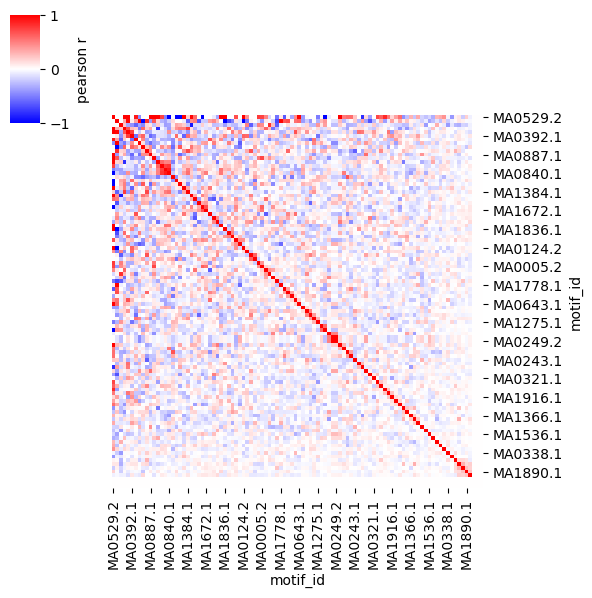

In [41]:
data = score_table
c = data[random_col].corr()

cg = sns.clustermap(c.fillna(0), cmap='bwr',
                    figsize=(6, 6), 
                    center=0, 
                    cbar_kws={"label":"pearson r"})
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

In [25]:
c.head()

motif_id,MA0001.2,MA0002.2,MA0003.4,MA0005.2,MA0007.3,MA0009.2,MA0010.1,MA0011.1,MA0012.1,MA0013.1,...,MA0113.3,MA0114.4,MA0115.1,MA0116.1,MA0117.2,MA0118.1,MA0119.1,MA0121.1,MA0122.3,MA0123.1
motif_id,,,,,,,,,,,,,,,,,,,,,
MA0001.2,1.000000,-0.032209,0.026032,0.351778,-0.100039,0.151577,-0.045277,0.148464,-0.154043,-0.014685,...,0.170525,0.037032,-0.095987,0.046644,-0.199868,-0.076073,-0.072378,0.042130,0.045248,-0.075677
MA0002.2,-0.032209,1.000000,-0.014727,0.021184,0.128638,0.073101,0.031158,-0.066370,-0.029941,0.001277,...,0.144364,-0.089195,0.061721,0.100722,-0.085749,-0.014624,0.000496,0.008603,0.103052,0.007462
MA0003.4,0.026032,-0.014727,1.000000,0.078796,-0.001404,0.137752,-0.071671,0.072201,0.168779,0.142928,...,0.031513,0.015499,-0.135763,0.015297,-0.157949,-0.366269,-0.061582,-0.064905,0.079621,-0.177135
MA0005.2,0.351778,0.021184,0.078796,1.000000,-0.037776,-0.181442,-0.002451,-0.170403,0.031649,0.014622,...,-0.053688,-0.054854,-0.163119,-0.005573,-0.171878,-0.113891,0.288666,0.173094,0.134980,-0.002726
MA0007.3,-0.100039,0.128638,-0.001404,-0.037776,1.000000,0.494485,0.088011,-0.175727,0.044219,0.241635,...,0.775703,-0.141334,0.160034,0.100502,-0.244083,-0.141262,0.057641,0.037789,-0.216818,0.017843


In [42]:
len(set(df["motif_id"]))

1677

In [43]:
df.head()

,motif_id,sequence_name,score,p-value
0,MA0010.1,BJ_down-DEG-prom_ENSG00000258064_chr12:7167293...,14.6757,0.000003
1,MA0010.1,BJ_down-DEG-prom_ENSG00000258064_chr12:7167318...,14.6757,0.000003
2,MA0010.1,BJ_down-DEG-prom_ENSG00000258064_chr12:7167422...,10.8108,0.000096
3,MA0010.1,BJ_down-DEG-prom_ENSG00000269900_chr9:35658038...,11.0270,0.000082
4,MA0010.1,BJ_up-DEG-prom_ENSG00000101353_chr20:37180833-...,11.9640,0.000042
